In [ ]:
# Install necessary libraries (though most are pre-installed in Colab)
!pip install pandas numpy scikit-learn matplotlib seaborn

# Import all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Metrics for evaluation
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
from google.colab import files

print("Please upload the new dataset (CSV or Excel file)...")
# uploaded = files.upload()

# --- IMPORTANT ---
# After downloading from Kaggle, rename the file or update this variable.
# The file from Kaggle is likely named 'Agriculture_Crop_Yield.csv'
file_name = "crop_yield.csv"
# -----------------

# Read the dataset into a pandas DataFrame
try:
    if file_name.endswith('.csv'):
        df = pd.read_csv(file_name)
    elif file_name.endswith('.xlsx'):
        df = pd.read_excel(file_name)
    else:
        print(f"Error: Unknown file type for {file_name}")

    print("Dataset loaded successfully!")
    df.head()

except KeyError:
    print("\n--- ERROR ---")
    print(f"File '{file_name}' not found. Did you upload it and spell the name correctly?")
except Exception as e:
    print(f"An error occurred: {e}")

Please upload the new dataset (CSV or Excel file)...
Dataset loaded successfully!


In [ ]:
# 1. Drop rows with any missing values
original_rows = len(df)
df = df.dropna()
print(f"Dropped {original_rows - len(df)} rows with missing data.")

# 2. Define Features (X) and Target (y)
# The target is our numerical yield
y = df['Yield_tons_per_hectare']

# The features are all columns EXCEPT the target
X = df.drop('Yield_tons_per_hectare', axis=1)

# 3. Identify which columns are categorical and which are numerical
# --- THIS IS THE CORRECTED PART ---
# We have removed 'Fertilizer_Amount_kg_per_hectare' from the numerical list.
# The 'Fertilizer_Used' column is already correctly listed as categorical.
categorical_features = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition', 'Fertilizer_Used', 'Irrigation_Used']
numerical_features = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']
# ---------------------------------

# Display the final features
print("\n--- Features (X) ---")
print(X.head())

Dropped 0 rows with missing data.

--- Features (X) ---
  Region Soil_Type     Crop  Rainfall_mm  Temperature_Celsius  \
0   West     Sandy   Cotton   897.077239            27.676966   
1  South      Clay     Rice   992.673282            18.026142   
2  North      Loam   Barley   147.998025            29.794042   
3  North     Sandy  Soybean   986.866331            16.644190   
4  South      Silt    Wheat   730.379174            31.620687   

   Fertilizer_Used  Irrigation_Used Weather_Condition  Days_to_Harvest  
0            False             True            Cloudy              122  
1             True             True             Rainy              140  
2            False            False             Sunny              106  
3            False             True             Rainy              146  
4             True             True            Cloudy              110  


In [ ]:
# Create a transformer for numerical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a transformer for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine these transformers into a single "preprocessor"
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# 1. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set has {len(X_train)} samples.")
print(f"Testing set has {len(X_test)} samples.\n")

# 2. Define the models we want to train
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# 3. Create a dictionary to store our results
model_results = {}

# 4. Loop through each model, train it, and store the results
for name, model in models.items():

    # Create the full pipeline: Preprocess data THEN run the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # --- Calculate Training "Accuracy" (R²) ---
    y_train_pred = pipeline.predict(X_train)
    train_r2 = r2_score(y_train, y_train_pred)

    # --- Calculate Testing "Accuracy" (R²) ---
    y_test_pred = pipeline.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print the results
    print(f"--- {name} ---")
    print(f"Training R² Score (Accuracy): {train_r2 * 100:.2f}%")
    print(f"Testing R² Score (Accuracy):  {test_r2 * 100:.2f}%")
    print("-" * (len(name) + 6) + "\n")

    # Store results for the graph
    model_results[name] = {
        'Train R² (%)': train_r2 * 100,
        'Test R² (%)': test_r2 * 100
    }

Training set has 800000 samples.
Testing set has 200000 samples.

--- Linear Regression ---
Training R² Score (Accuracy): 91.30%
Testing R² Score (Accuracy):  91.30%
-----------------------

--- Random Forest ---
Training R² Score (Accuracy): 98.71%
Testing R² Score (Accuracy):  90.77%
-------------------

--- Gradient Boosting ---
Training R² Score (Accuracy): 91.26%
Testing R² Score (Accuracy):  91.25%
-----------------------



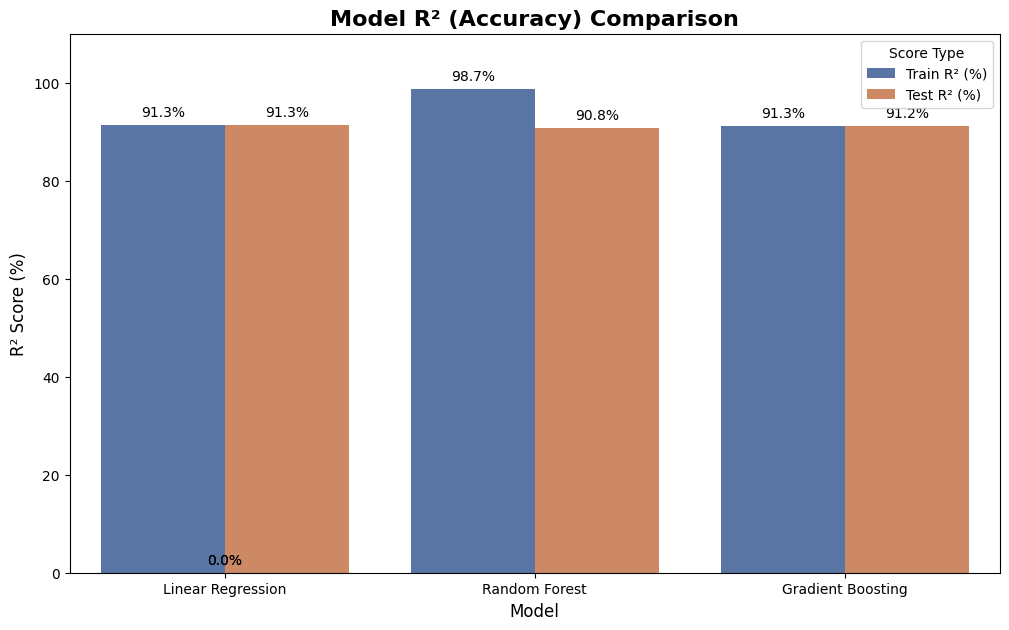

In [ ]:
# Convert the results dictionary into a pandas DataFrame for easy plotting
results_df = pd.DataFrame(model_results).T.reset_index()
results_df = results_df.rename(columns={'index': 'Model'})

# "Melt" the DataFrame to a "long" format, which is what seaborn likes
plot_df = results_df.melt(id_vars='Model', var_name='Metric', value_name='R² Score (%)')

# Create the bar plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=plot_df,
    x='Model',
    y='R² Score (%)',
    hue='Metric',
    palette=['#4C72B0', '#DD8452'] # Blue for Train, Orange for Test
)

# Add titles and labels
plt.title('Model R² (Accuracy) Comparison', fontsize=16, fontweight='bold')
plt.ylabel('R² Score (%)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 110) # Set Y-axis from 0% to 110%
plt.legend(title='Score Type')

# Add the percentage labels on top of each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontweight='medium'
    )

plt.show()

In [ ]:
import joblib
import os

# Create a directory to save the models
model_dir = "trained_models"
os.makedirs(model_dir, exist_ok=True)

# Save each trained model
for name, model in models.items():
    # The trained model is the 'regressor' step in the pipeline
    trained_model = pipeline.named_steps['regressor']

    # Sanitize model name for filename
    safe_name = name.replace(" ", "_").lower()
    filename = os.path.join(model_dir, f"{safe_name}_model.joblib")

    joblib.dump(trained_model, filename)
    print(f"Saved {name} model to {filename}")

Saved Linear Regression model to trained_models/linear_regression_model.joblib
Saved Random Forest model to trained_models/random_forest_model.joblib
Saved Gradient Boosting model to trained_models/gradient_boosting_model.joblib
